In this project, I am going to predict whether a breast cancer is malignant or benign based on the features available. This dataset is obtained from https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

The columns are as follows:

Categorical: <br>
    1) ID number <br>
    2) Diagnosis (M = malignant, B = benign)

Ten real-valued features computed for each cell nucleus: <br>
a) radius (mean of distances from center to points on the perimeter)<br>
b) texture (standard deviation of gray-scale values)<br>
c) perimeter<br>
d) area<br>
e) smoothness (local variation in radius lengths)<br>
f) compactness (perimeter^2 / area - 1.0)<br>
g) concavity (severity of concave portions of the contour)<br>
h) concave points (number of concave portions of the contour)<br>
i) symmetry<br>
j) fractal dimension ("coastline approximation" - 1)<br>

The mean, standard error ("se") and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import dataset
df = pd.read_csv('data.csv')

# Check the top 5 rows
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# Check the overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

# Preprocessing

Drop unimportant columns: `id` and `Unnamed: 32`.

In [4]:
df.drop(['id','Unnamed: 32'],axis=1,inplace=True)

Since all of the features are already set as float and there are no missing values, we can proceed to check whether there are duplicated rows.

In [5]:
df.duplicated().sum()

0

So our dataset is already free from missing values and duplicated rows. Next, I'm going to do label encoding on our target variable, `diagnosis`, where malignant (M) cases will be set as 1's and benign cases will be set as 0's.

In [6]:
# Binary encoding for target variable
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})

# EDA

           percentage
diagnosis            
0           62.741652
1           37.258348


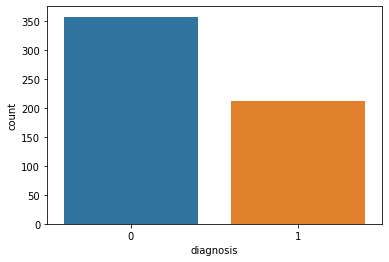

In [7]:
# Check the distribution of the target
print(pd.DataFrame(data=df['diagnosis'].value_counts(normalize=True).values*100,columns=['percentage']).rename_axis('diagnosis'))

sns.countplot(x=df['diagnosis'])

So we are dealing with quite an imbalanced dataset, where we have 1.5 times more benign cases than malignant ones, which is expected, since the more severe cases should be rarer. This imbalance is not so severe, so balancing might not be required.

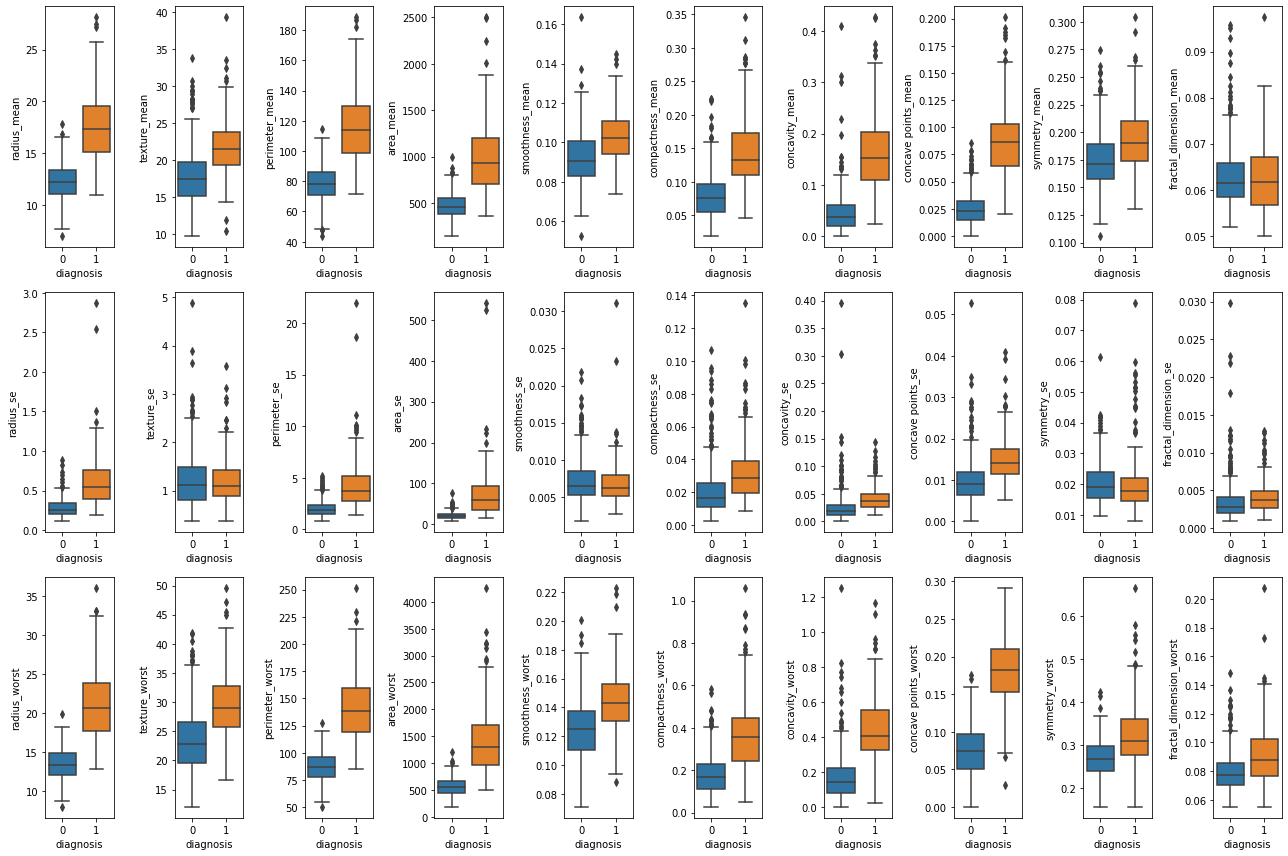

In [8]:
# Checking the distributions for all features using boxplot
features = df.drop('diagnosis',axis=1)

plt.figure(figsize=(18,12))
for i,col in enumerate(features):
    plt.subplot(3,len(features.columns)//3,i+1)
    sns.boxplot(y=col,x='diagnosis',data=df)
    plt.tight_layout()

From the boxplot alone, it is quite clear that the malignant cases have larger mean values for all the features (e.g larger radius, perimeter, and area), which are to be expected, except for `fractal_dimension_mean`. The malignant cases also seem to have larger standard errors for their measurements, which could be correlated with their mean values. 


Also, there does not seem to be any outlier in all of the features.

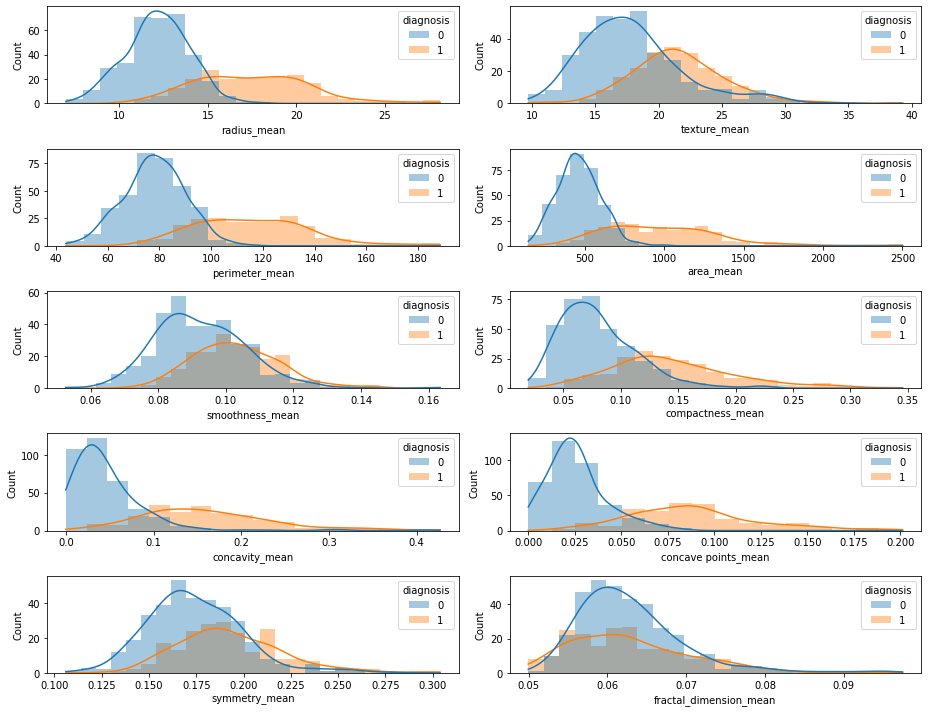

In [9]:
# Visualize the distribution using histogram
# For the _mean features
mean_columns = df[df.columns[df.columns.str.contains('mean')]].columns.tolist()

# Make figure and axis objects
fig, axes = plt.subplots(5,len(mean_columns)//5,figsize=(13,10))

for i, ax in enumerate(fig.axes):
    sns.histplot(x=mean_columns[i],data=df,ax=ax,kde=True,alpha=0.4,color='skyblue',edgecolor=None,hue='diagnosis')

plt.tight_layout()

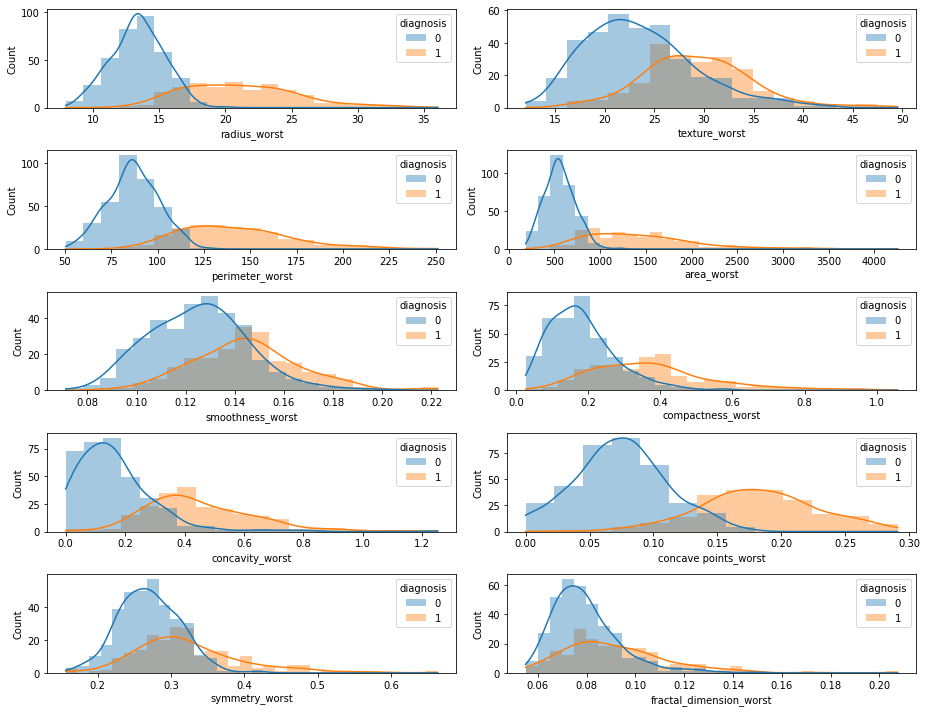

In [10]:
# Visualize the distribution using histogram
# For the _worst features
worst_columns = df[df.columns[df.columns.str.contains('worst')]].columns.tolist()

# Make figure and axis objects
fig, axes = plt.subplots(5,len(worst_columns)//5,figsize=(13,10))

for i, ax in enumerate(fig.axes):
    sns.histplot(x=worst_columns[i],data=df,ax=ax,kde=True,alpha=0.4,color='skyblue',edgecolor=None,hue='diagnosis')

plt.tight_layout()

It is very apparent that the malignant cases are distributed on larger values.

I think we have gained enough insight about the entirety of this dataset. I am going to select the features that will be used as predictors for `diagnosis`.

# Feature Selection

### Train-Test Split 

To prevent information leakage in any way possible, I am going to split the data into training and test set now.

In [11]:
# Import the function
from sklearn.model_selection import train_test_split

# Define feature variable
X = df.drop('diagnosis',axis=1)
y = df[['diagnosis']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Combine the training set (for convenience)
df_train = X_train.join(y_train)

First, I would like to investigate the correlation between `_mean` features and `_worst` features, since they should be highly correlated with each other.

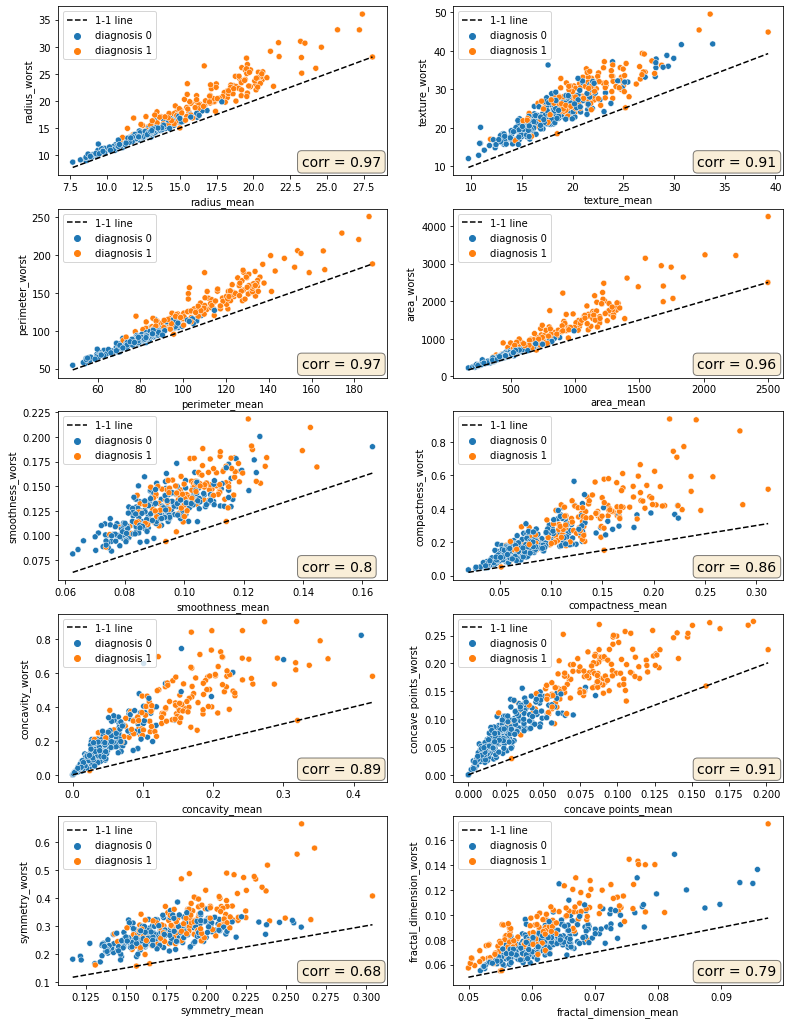

In [12]:
# Scatter plot for _mean vs _worst

# Make figure and axis objects
fig, axes = plt.subplots(5,len(mean_columns)//5,figsize=(13,18))

for i, ax in enumerate(fig.axes):
    sns.scatterplot(x=mean_columns[i],y=worst_columns[i],data=df_train,ax=ax,hue='diagnosis')

    # Make 1-1 line
    xmin = df_train[mean_columns[i]].min()
    xmax = df_train[mean_columns[i]].max()
    x_ = np.linspace(xmin,xmax,2)
    ax.plot(x_,x_,color='k',ls='--',label='1-1 line')
    
    # Change legend labels
    handles, labels = ax.get_legend_handles_labels()
    labels[1] = 'diagnosis 0'
    labels[2] = 'diagnosis 1'
    ax.legend(handles=handles, labels=labels, loc='upper left')
    
    # Calculate the correlation between each pair
    corr = df_train[[mean_columns[i],worst_columns[i]]].corr().values[0,1]
    
    textstr = 'corr = ' + str(round(corr,2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.74,0.12, textstr, fontsize=14,transform=ax.transAxes,
            verticalalignment='top', bbox=props)

As expected, the `_mean` features are highly correlated with the `_worst` features, and the `_worst` features are systematically larger than the `_mean` features. However, for some features like `compactness` and `concavity`, the two features do not seem to follow a one-to-one relationship.

Therefore, since these two classes of features are redundant, I am going to use the class that has a higher overall correlation with `diagnosis`. To find the correlation between a continuous variable and a binary variable, we can use the point-biserial correlation (which is actually just a special case of the Pearson correlation).

In [13]:
# Import the point-biserial function
from scipy.stats import pointbiserialr

# Initiate empty lists to store the correlation values
corr_mean = []
corr_worst = []

# Calculate the point-biserial correlation for mean vs diagnosis and worst vs diagnosis
for col_mean,col_worst in zip(mean_columns,worst_columns):
    corr_mean.append(pointbiserialr(df_train[col_mean],df_train['diagnosis'])[0])
    corr_worst.append(pointbiserialr(df_train[col_worst],df_train['diagnosis'])[0])
    
# Summarize the results in a dataframe
df_corr = pd.DataFrame()
df_corr['features'] = X_train[worst_columns].columns
df_corr['features'] = df_corr['features'].apply(lambda x: x.split('_')[0])
df_corr['_mean'] = corr_mean
df_corr['_worst'] = corr_worst

df_corr

,features,_mean,_worst
0,radius,0.712933,0.761693
1,texture,0.406121,0.455530
2,perimeter,0.726666,0.770895
3,area,0.688087,0.715231
4,smoothness,0.357168,0.405991
5,compactness,0.582411,0.581583
6,concavity,0.691392,0.674592
7,concave points,0.780350,0.791089
8,symmetry,0.351107,0.433798
9,fractal,-0.032082,0.290516


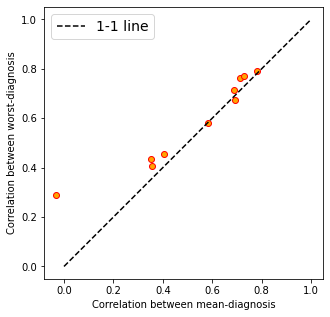

In [14]:
# Plot the comparison
plt.figure(figsize=(5,5))
plt.scatter(corr_mean,corr_worst,edgecolor='red',facecolor='orange')
plt.xlabel('Correlation between mean-diagnosis')
plt.ylabel('Correlation between worst-diagnosis')
plt.axis('equal')
plt.plot([0.,1.],[0.,1.],color='k',ls='--',label='1-1 line')
plt.legend(fontsize=14)

It can be seen that the `_worst` features in overall have larger correlation with `diagnosis`, and so I am going to use it for the rest of the analysis.

In [15]:
# Drop the _mean features
X_train.drop(mean_columns,axis=1,inplace=True)
X_test.drop(mean_columns,axis=1,inplace=True)

Next, I am going to investigate the correlation between every `_worst` feature.

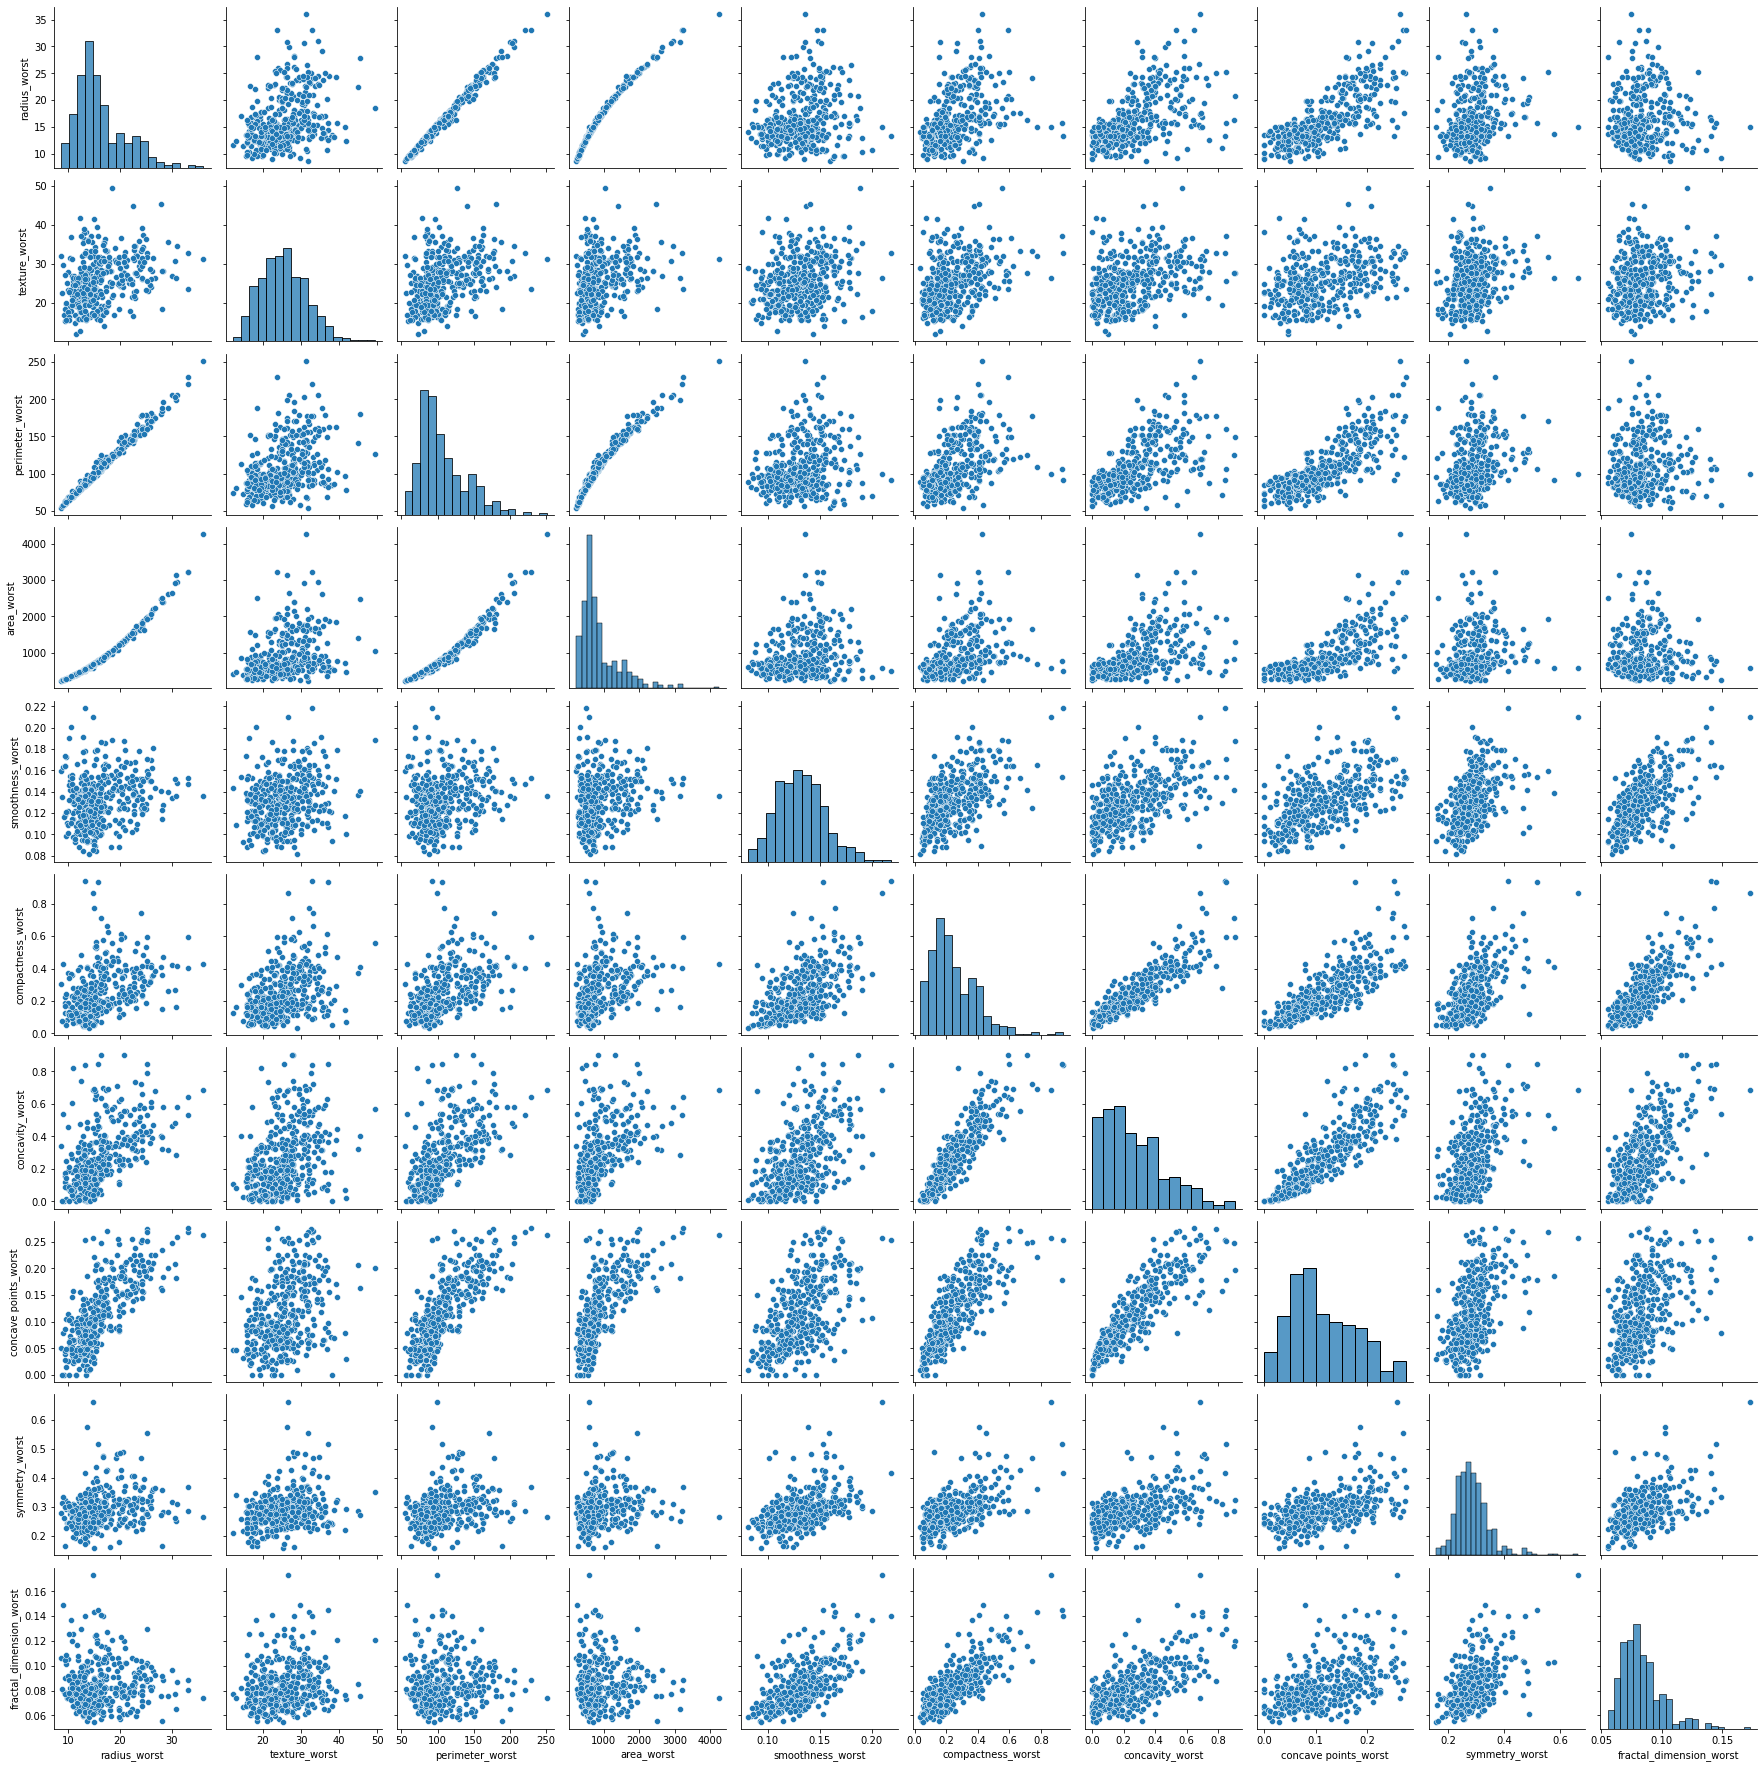

In [16]:
sns.pairplot(X_train[worst_columns])

There are some correlated features, but the most visible ones are `radius_worst` and `perimeter_worst`, `radius_worst` and `area_worst`, and `perimeter_worst` and `area_worst`. These are perfectly reasonable, since for a circular shape, perimeter and area both can be directly derived from the radius.

Because the previous analysis shows that `perimeter` correlates more with `diagnosis`, I am dropping `radius` and `area` from the features.

In [17]:
# Drop radius and area
X_train.drop(['radius_worst','area_worst'],axis=1,inplace=True)
X_test.drop(['radius_worst','area_worst'],axis=1,inplace=True)

# Building the Model

The dataset seems to be linearly separable, so I am going to use logistic regression and SVM to predict `diagnosis`.

### Model I: Logistic Regression

In [18]:
# Import the model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42,max_iter=1000)

We want a model with a good recall, since in this case, false negatives are not desired, i.e. it is better to falsely diagnose someone with a malignant cancer than to permit them.

I am also using the grid search method to optimize the hyperparameters.

In [19]:
# Import GridSearch
from sklearn.model_selection import GridSearchCV

# hyperparameter values to be tuned
param_grid = {'C': np.logspace(-2,2,5),
              'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'penalty': ['l1','l2']}

# the tuning
logreg_gridcv = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, 
                                scoring='recall',verbose=3)
logreg_gridcv.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.633 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=libli

[CV 3/5] END C=10.0, penalty=l1, solver=liblinear;, score=1.000 total time=   0.0s
[CV 4/5] END C=10.0, penalty=l1, solver=liblinear;, score=0.931 total time=   0.0s
[CV 5/5] END C=10.0, penalty=l1, solver=liblinear;, score=0.933 total time=   0.0s
[CV 1/5] END C=10.0, penalty=l2, solver=newton-cg;, score=0.967 total time=   0.0s
[CV 2/5] END C=10.0, penalty=l2, solver=newton-cg;, score=0.867 total time=   0.0s
[CV 3/5] END C=10.0, penalty=l2, solver=newton-cg;, score=0.967 total time=   0.0s
[CV 4/5] END C=10.0, penalty=l2, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 5/5] END C=10.0, penalty=l2, solver=newton-cg;, score=0.900 total time=   0.0s
[CV 1/5] END ..C=10.0, penalty=l2, solver=lbfgs;, score=0.967 total time=   0.0s
[CV 2/5] END ..C=10.0, penalty=l2, solver=lbfgs;, score=0.867 total time=   0.0s
[CV 3/5] END ..C=10.0, penalty=l2, solver=lbfgs;, score=0.967 total time=   0.1s
[CV 4/5] END ..C=10.0, penalty=l2, solver=lbfgs;, score=0.931 total time=   0.1s
[CV 5/5] END

/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='recall', verbose=3)

In [20]:
# Results from grid search
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result = pd.DataFrame(logreg_gridcv.cv_results_)
cv_result[retain_cols].sort_values(by='rank_test_score').head(10)

,params,mean_test_score,rank_test_score
29,"{'C': 100.0, 'penalty': 'l2', 'solver': 'libli...",0.946207,1
27,"{'C': 100.0, 'penalty': 'l2', 'solver': 'newto...",0.946207,1
28,"{'C': 100.0, 'penalty': 'l2', 'solver': 'lbfgs'}",0.946207,1
26,"{'C': 100.0, 'penalty': 'l1', 'solver': 'libli...",0.945977,4
20,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.939540,5
22,"{'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}",0.926207,6
21,"{'C': 10.0, 'penalty': 'l2', 'solver': 'newton...",0.926207,6
23,"{'C': 10.0, 'penalty': 'l2', 'solver': 'liblin...",0.919540,8
14,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",0.919310,9
15,"{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-...",0.905747,10


In [21]:
# Print the best hyperparameters
print(f'Best hyperparameters: {logreg_gridcv.best_params_}')

# Fit again using the best hyperparameter combination
logreg_best = logreg_gridcv.best_params_
logreg = LogisticRegression(random_state=42,max_iter=1000,
                            C=logreg_best['C'],
                            penalty=logreg_best['penalty'],
                            solver=logreg_best['solver'])

# Train the model
logreg.fit(X_train, y_train.values.ravel())

# Predict the test set
y_pred_logreg = logreg.predict(X_test)

Best hyperparameters: {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [22]:
# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, recall_score

def print_eval(model,y_true,y_pred):
    print(f'The accuracy of the {model} model is {round(accuracy_score(y_true,y_pred),2)*100}%')
    print(f'The recall of the {model} model is {round(recall_score(y_true,y_pred),2)*100}%')
    print(f'The AUC score of the {model} model is {round(roc_auc_score(y_true,y_pred),2)*100}%')
    print('\n')
    print(f'Confusion matrix: \n {confusion_matrix(y_true,y_pred)}')
    
print_eval('logistic regression',y_test,y_pred_logreg)

The accuracy of the logistic regression model is 98.0%
The recall of the logistic regression model is 98.0%
The AUC score of the logistic regression model is 98.0%


Confusion matrix: 
 [[105   3]
 [  1  62]]


It looks like the logistic regression already gives a fantastic result.

### Model II: Support Vector Machine (SVM)

In [23]:
# Import support vector classifier
from sklearn.svm import SVC

svc = SVC(random_state=42)

In [24]:
# hyperparameter values to be tuned
param_grid = {'C': np.logspace(-2,2,5),
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf','linear']} 

# the tuning
svc_gridcv = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, 
                                scoring='recall',verbose=3)
svc_gridcv.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 1/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.900 total time=   0.0s
[CV 2/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.900 total time=   0.0s
[CV 3/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.933 total time=   0.0s
[CV 4/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.793 total time=   0.0s
[CV 5/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.867 total time=   0.0s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf

[CV 1/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.967 total time=   0.0s
[CV 2/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.867 total time=   0.0s
[CV 3/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.967 total time=   0.0s
[CV 4/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.897 total time=   0.0s
[CV 5/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.867 total time=   0.0s
[CV 1/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.400 total time=   0.0s
[CV 2/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.233 total time=   0.0s
[CV 3/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.433 total time=   0.0s
[CV 4/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.448 total time=   0.0s
[CV 5/5] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.367 total time=   0.0s
[CV 1/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.967 total time=   0.0s
[CV 2/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.867 total time=   0.0s
[CV 3/5] END ...C=1.0, gamma

[CV 3/5] END ...C=100.0, gamma=1, kernel=linear;, score=1.000 total time=   0.8s
[CV 4/5] END ...C=100.0, gamma=1, kernel=linear;, score=0.931 total time=   0.3s
[CV 5/5] END ...C=100.0, gamma=1, kernel=linear;, score=0.967 total time=   0.6s
[CV 1/5] END ....C=100.0, gamma=0.1, kernel=rbf;, score=0.400 total time=   0.0s
[CV 2/5] END ....C=100.0, gamma=0.1, kernel=rbf;, score=0.233 total time=   0.0s
[CV 3/5] END ....C=100.0, gamma=0.1, kernel=rbf;, score=0.533 total time=   0.0s
[CV 4/5] END ....C=100.0, gamma=0.1, kernel=rbf;, score=0.483 total time=   0.0s
[CV 5/5] END ....C=100.0, gamma=0.1, kernel=rbf;, score=0.400 total time=   0.0s
[CV 1/5] END .C=100.0, gamma=0.1, kernel=linear;, score=1.000 total time=   1.5s
[CV 2/5] END .C=100.0, gamma=0.1, kernel=linear;, score=0.900 total time=   0.3s
[CV 3/5] END .C=100.0, gamma=0.1, kernel=linear;, score=1.000 total time=   0.8s
[CV 4/5] END .C=100.0, gamma=0.1, kernel=linear;, score=0.931 total time=   0.3s
[CV 5/5] END .C=100.0, gamma

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             scoring='recall', verbose=3)

In [25]:
# Results from grid search
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result = pd.DataFrame(svc_gridcv.cv_results_)
cv_result[retain_cols].sort_values(by='rank_test_score').head(10)

,params,mean_test_score,rank_test_score
49,"{'C': 100.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.95954,1
47,"{'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}",0.95954,1
45,"{'C': 100.0, 'gamma': 0.01, 'kernel': 'linear'}",0.95954,1
43,"{'C': 100.0, 'gamma': 0.1, 'kernel': 'linear'}",0.95954,1
41,"{'C': 100.0, 'gamma': 1, 'kernel': 'linear'}",0.95954,1
39,"{'C': 10.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.93954,6
37,"{'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'}",0.93954,6
35,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'linear'}",0.93954,6
33,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'linear'}",0.93954,6
31,"{'C': 10.0, 'gamma': 1, 'kernel': 'linear'}",0.93954,6


In [26]:
# Print the best hyperparameters
print(f'Best hyperparameters: {svc_gridcv.best_params_}')

# Fit again using the best hyperparameter combination
svc_best = svc_gridcv.best_params_
svc = SVC(random_state=42,
          C=svc_best['C'],
          gamma=svc_best['gamma'],
          kernel=svc_best['kernel'])

# Train the model
svc.fit(X_train, y_train.values.ravel())

# Predict the test set
y_pred_svc = svc.predict(X_test)

Best hyperparameters: {'C': 100.0, 'gamma': 1, 'kernel': 'linear'}


In [27]:
# Evaluate the model
print_eval('SVM',y_test,y_pred_svc)

The accuracy of the SVM model is 96.0%
The recall of the SVM model is 97.0%
The AUC score of the SVM model is 97.0%


Confusion matrix: 
 [[104   4]
 [  2  61]]


The SVM also gives a fantastic result. However, compared to logistic regression, it has a lower recall, since now there is 1 more false negative.

# Feature Selection with PCA

We have acquired great results with both logistic regression and SVM. But I would like to implement PCA to carry out feature selection, and see if we can improve the results.

For this purpose, I am going to use the full dataset again (but still dropping the useless features such as ID).

In [28]:
# Import dataset
df = pd.read_csv('data.csv')

# Drop useless columns
df.drop(['id','Unnamed: 32'],axis=1,inplace=True)

# Binary encoding for target variable
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})

### Train-Test Split 

In [29]:
# Define feature variable
X = df.drop('diagnosis',axis=1)
y = df[['diagnosis']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Combine the training set (for convenience)
df_train = X_train.join(y_train)

Before performing PCA on the features, we have to scale them first.

In [30]:
# Import standardscaler from sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

# Scale the training and test set
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### PCA 

In [31]:
from sklearn.decomposition import PCA

# Let's try 5 components
pca = PCA(n_components=5)
pca.fit(X_train_std)
pcs = pca.transform(X_train_std)

pdf = pd.DataFrame(data = pcs, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pdf['diagnosis'] = y_train['diagnosis'].values
pdf.head()

,PC1,PC2,PC3,PC4,PC5,diagnosis
0,-3.084842,-2.158704,-0.339875,-0.216630,1.545359,0
1,-2.182647,-0.617571,0.447208,-0.150818,2.860346,0
2,2.049959,2.328953,1.169407,-1.814647,-0.115599,0
3,-2.809267,-0.950791,-0.305102,-0.380816,0.547114,0
4,-1.913537,-1.072582,0.498365,1.311554,-0.204212,0


Explained variance: [12.98286419  5.96869224  2.92730279  1.96440795  1.56758402]
Explained variance ratio: [0.4316748  0.19845652 0.09733159 0.06531574 0.05212151]


<BarContainer object of 5 artists>

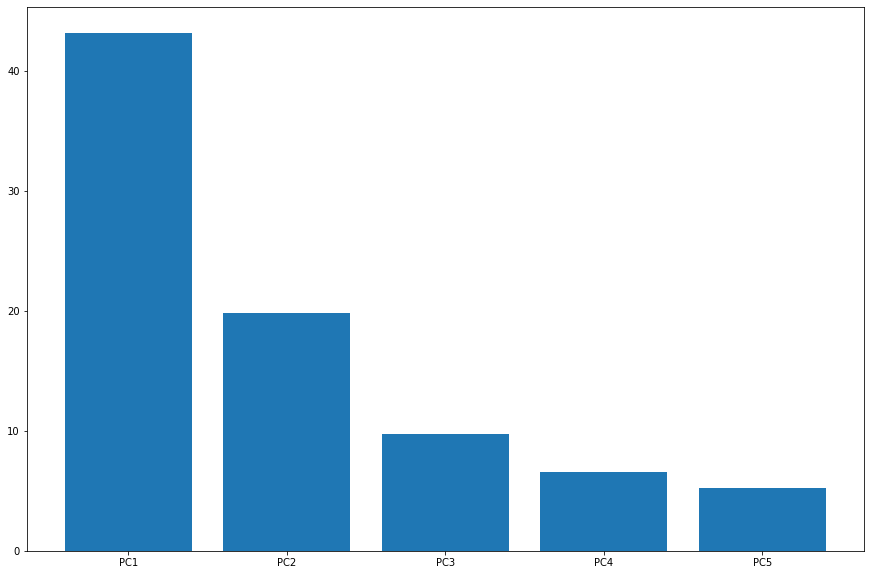

In [32]:
# Make skree plot
print('Explained variance:', pca.explained_variance_)
print('Explained variance ratio:', pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(15,10))
plt.bar(['PC1', 'PC2', 'PC3', 'PC4','PC5'], pca.explained_variance_ratio_ * 100)

From the skree plot above, using only 2 principal components will only preserve about 60% of the information in the original data.

Let's try plotting the data in the 2 principal components and see what happens.

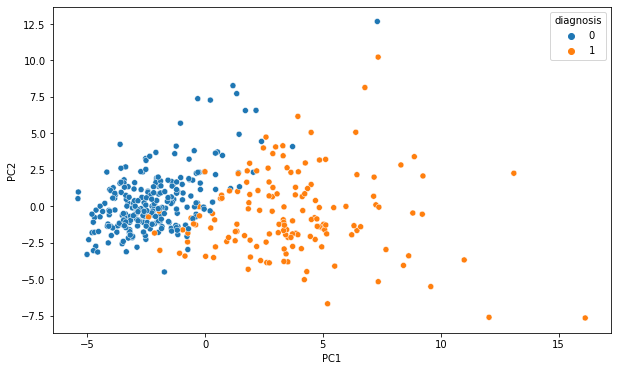

In [33]:
# Plot the data along PC1 and PC2
plt.figure(figsize=(10,6))
sns.scatterplot(x='PC1',y='PC2',data=pdf,hue='diagnosis')

Now, the separation between the two cases is even more clear. So, I am going to use only 2 principal components to predict `diagnosis`.

In [34]:
# Using 2 PC's only
pca = PCA(n_components=2)
pca.fit(X_train_std)

# Transform the train and test set
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

Let's build the model again.

### Model I: Logistic Regression

In [35]:
logreg = LogisticRegression(random_state=42,max_iter=1000)

In [36]:
# hyperparameter values to be tuned
param_grid = {'C': np.logspace(-2,2,5),
              'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'penalty': ['l1','l2']}

# the tuning
logreg_gridcv = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, 
                                scoring='recall',verbose=3)
logreg_gridcv.fit(X_train_pca,y_train.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.900 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=libli

[CV 2/5] END ...C=100.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ...C=100.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ...C=100.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ...C=100.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=100.0, penalty=l1, solver=liblinear;, score=0.933 total time=   0.0s
[CV 2/5] END C=100.0, penalty=l1, solver=liblinear;, score=0.933 total time=   0.0s
[CV 3/5] END C=100.0, penalty=l1, solver=liblinear;, score=0.933 total time=   0.0s
[CV 4/5] END C=100.0, penalty=l1, solver=liblinear;, score=0.862 total time=   0.0s
[CV 5/5] END C=100.0, penalty=l1, solver=liblinear;, score=0.933 total time=   0.0s
[CV 1/5] END C=100.0, penalty=l2, solver=newton-cg;, score=0.933 total time=   0.0s
[CV 2/5] END C=100.0, penalty=l2, solver=newton-cg;, score=0.933 total time=   0.0s
[CV 3/5] END C=100.0, penalty=l2, solver=newton-cg;, score=0.933 total time=   0.0s
[CV 

/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='recall', verbose=3)

In [37]:
# Results from grid search
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result = pd.DataFrame(logreg_gridcv.cv_results_)
cv_result[retain_cols].sort_values(by='rank_test_score').head(10)

,params,mean_test_score,rank_test_score
8,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.945977,1
14,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",0.925747,2
27,"{'C': 100.0, 'penalty': 'l2', 'solver': 'newto...",0.919080,3
26,"{'C': 100.0, 'penalty': 'l1', 'solver': 'libli...",0.919080,3
23,"{'C': 10.0, 'penalty': 'l2', 'solver': 'liblin...",0.919080,3
22,"{'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}",0.919080,3
21,"{'C': 10.0, 'penalty': 'l2', 'solver': 'newton...",0.919080,3
20,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.919080,3
17,"{'C': 1.0, 'penalty': 'l2', 'solver': 'libline...",0.919080,3
16,"{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}",0.919080,3


In [38]:
# Print the best hyperparameters
print(f'Best hyperparameters: {logreg_gridcv.best_params_}')

# Fit again using the best hyperparameter combination
logreg_best = logreg_gridcv.best_params_
logreg = LogisticRegression(random_state=42,max_iter=1000,
                            C=logreg_best['C'],
                            penalty=logreg_best['penalty'],
                            solver=logreg_best['solver'])

# Train the model
logreg.fit(X_train_pca, y_train.values.ravel())

# Predict the test set
y_pred_logreg = logreg.predict(X_test_pca)

Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [39]:
# Evaluate the model
print_eval('logistic regression',y_test,y_pred_logreg)

The accuracy of the logistic regression model is 98.0%
The recall of the logistic regression model is 98.0%
The AUC score of the logistic regression model is 98.0%


Confusion matrix: 
 [[106   2]
 [  1  62]]


The recall score for logistic regression stays the same because there is still one false negative. However, the accuracy has improved slightly because we have eliminated one false positive.

### Model II: SVM

In [40]:
# Create an instance
svc = SVC(random_state=42)

# hyperparameter values to be tuned
param_grid = {'C': np.logspace(-2,2,5),
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf','linear']} 

# the tuning
svc_gridcv = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, 
                                scoring='recall',verbose=3)
svc_gridcv.fit(X_train_pca, y_train.values.ravel())

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 1/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.867 total time=   0.0s
[CV 2/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.900 total time=   0.0s
[CV 3/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.900 total time=   0.0s
[CV 4/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.828 total time=   0.0s
[CV 5/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.800 total time=   0.0s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf

[CV 5/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.933 total time=   0.0s
[CV 1/5] END .....C=1.0, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 2/5] END .....C=1.0, gamma=0.01, kernel=rbf;, score=0.900 total time=   0.0s
[CV 3/5] END .....C=1.0, gamma=0.01, kernel=rbf;, score=0.900 total time=   0.0s
[CV 4/5] END .....C=1.0, gamma=0.01, kernel=rbf;, score=0.862 total time=   0.0s
[CV 5/5] END .....C=1.0, gamma=0.01, kernel=rbf;, score=0.800 total time=   0.0s
[CV 1/5] END ..C=1.0, gamma=0.01, kernel=linear;, score=0.900 total time=   0.0s
[CV 2/5] END ..C=1.0, gamma=0.01, kernel=linear;, score=0.967 total time=   0.0s
[CV 3/5] END ..C=1.0, gamma=0.01, kernel=linear;, score=0.933 total time=   0.0s
[CV 4/5] END ..C=1.0, gamma=0.01, kernel=linear;, score=0.862 total time=   0.0s
[CV 5/5] END ..C=1.0, gamma=0.01, kernel=linear;, score=0.933 total time=   0.0s
[CV 1/5] END ....C=1.0, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/5] END ....C=1.0, gamm

[CV 2/5] END C=100.0, gamma=0.01, kernel=linear;, score=0.967 total time=   0.1s
[CV 3/5] END C=100.0, gamma=0.01, kernel=linear;, score=0.933 total time=   0.0s
[CV 4/5] END C=100.0, gamma=0.01, kernel=linear;, score=0.862 total time=   0.0s
[CV 5/5] END C=100.0, gamma=0.01, kernel=linear;, score=0.933 total time=   0.0s
[CV 1/5] END ..C=100.0, gamma=0.001, kernel=rbf;, score=0.900 total time=   0.0s
[CV 2/5] END ..C=100.0, gamma=0.001, kernel=rbf;, score=0.967 total time=   0.0s
[CV 3/5] END ..C=100.0, gamma=0.001, kernel=rbf;, score=0.900 total time=   0.0s
[CV 4/5] END ..C=100.0, gamma=0.001, kernel=rbf;, score=0.862 total time=   0.0s
[CV 5/5] END ..C=100.0, gamma=0.001, kernel=rbf;, score=0.933 total time=   0.0s
[CV 1/5] END C=100.0, gamma=0.001, kernel=linear;, score=0.900 total time=   0.1s
[CV 2/5] END C=100.0, gamma=0.001, kernel=linear;, score=0.967 total time=   0.1s
[CV 3/5] END C=100.0, gamma=0.001, kernel=linear;, score=0.933 total time=   0.0s
[CV 4/5] END C=100.0, gam

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             scoring='recall', verbose=3)

In [41]:
# Results from grid search
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result = pd.DataFrame(svc_gridcv.cv_results_)
cv_result[retain_cols].sort_values(by='rank_test_score').head(10)

,params,mean_test_score,rank_test_score
49,"{'C': 100.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.91908,1
35,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'linear'}",0.91908,1
21,"{'C': 1.0, 'gamma': 1, 'kernel': 'linear'}",0.91908,1
23,"{'C': 1.0, 'gamma': 0.1, 'kernel': 'linear'}",0.91908,1
37,"{'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'}",0.91908,1
39,"{'C': 10.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.91908,1
29,"{'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.91908,1
25,"{'C': 1.0, 'gamma': 0.01, 'kernel': 'linear'}",0.91908,1
27,"{'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}",0.91908,1
43,"{'C': 100.0, 'gamma': 0.1, 'kernel': 'linear'}",0.91908,1


In [42]:
# Print the best hyperparameters
print(f'Best hyperparameters: {svc_gridcv.best_params_}')

# Fit again using the best hyperparameter combination
svc_best = svc_gridcv.best_params_
svc = SVC(random_state=42,
          C=svc_best['C'],
          gamma=svc_best['gamma'],
          kernel=svc_best['kernel'])

# Train the model
svc.fit(X_train_pca, y_train.values.ravel())

# Predict the test set
y_pred_svc = svc.predict(X_test_pca)

Best hyperparameters: {'C': 1.0, 'gamma': 1, 'kernel': 'linear'}


In [43]:
# Evaluate the model
print_eval('SVM',y_test,y_pred_svc)

The accuracy of the SVM model is 97.0%
The recall of the SVM model is 95.0%
The AUC score of the SVM model is 97.0%


Confusion matrix: 
 [[106   2]
 [  3  60]]


Unfortunately, for the SVM model, using PCA has increased the false negative, and so lowering the recall score to 95%. However, we have increased the accuracy to 97% by removing some false positives.

# Conclusion

1. I have analyzed and performed a classification task on the 'Breast Cancer' dataset obtained from Kaggle.
2. This dataset contains 33 columns, 2 of which are useless (`id` and `Unnamed`), 30 of which are the features, and the target `diagnosis` is binary, where malignant cases are labeled as 1's and benign cases are labeled as 0.
3. The target is slightly biased towards higher benign cases, which is normal since severe cases should be rarer.
4. Based on EDA, I find that malignant cases have larger values for all of the features, compared to the benign cases.
5. By doing feature selection manually, I drop all of the `_mean` features, `radius_worst`, and `area_worst` because they exhibit multicollinearity.
6. Both logistic regression and SVM perform extremely well on this dataset, with a recall score of 98% for logistic regression and a slightly lower score of 97% for SVM. This is expected since the target `diagnosis` seems to be linearly separable.
7. Using PCA to do feature selection and using only 2 of the principal components, I find that this does not change the recall score for the logistic regression model, but it slightly increases the accuracy of the model. For SVM, however, the recall score drops to 95% but the accuracy increases to 97%.
8. Even though there are no significant improvements on the recall scores by using PCA, the feature selection is made very efficient and easy.